# Classifying School Budgets 
## Springboard Capstone 2018

<b>Description and Objective</b>: School budgets are often overwhelmingly complex and messy. The education nonprofit, Education Resource Strategies, is routinely given schools' budget data and asked to analyze, summarize, and derive actionable insights on spending strategies. However, the budget data ERS receives is often recorded at the line-item level, with inconsistent freeform text, which makes it difficult to holistically identify major areas of spending and compare budgets across schools and districts. ERS spends hundreds of analyst hours manually "financially coding" the data by attaching broad labels to every line-item with the goal of summarizing and comparing spending across schools and districts. By coming up with an algorithm that is able to streamline the process of categorizing budget line items by predicting and assigning labels to each line item, ERS will be able to significantly reduce analyst time spent manually combing through entries and instead focus their resources on analyzing and strategizing with their clients.

<b>Data Source</b>:
Data are from ERS' submission on the "Box Plots for Education" competition on Driven Data. See: https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/

<b>1. Set up and load data</b>

In [1]:
#set up and load data
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

budget_df=pd.read_csv('Data/Budget Data/LabledBudgetData.csv', index_col=0)

<b>2. Exploratory Data Analysis and Data Cleaning</b>

In [2]:
#explore data
budget_df.describe()

budget_df.info()

budget_df.tail()

# Print the summary statistics
print(budget_df.describe())

# multiply FTE variable by 100 for better representation in graph
budget_df[budget_df['FTE'].notnull()]=budget_df[budget_df['FTE'].notnull()]*100

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

(0, 100)

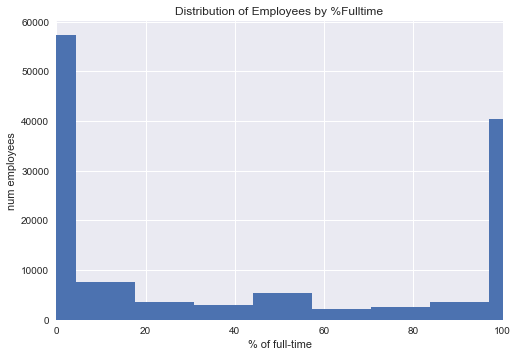

In [3]:
# how are the employees distributed according to their hours? 
# Create the histogram
n_bins = int(np.sqrt(len(budget_df['FTE'].dropna())))
plt.hist(budget_df['FTE'].dropna(),bins=n_bins)

# Add title and labels
plt.title('Distribution of Employees by %Fulltime')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.xlim(0,100)

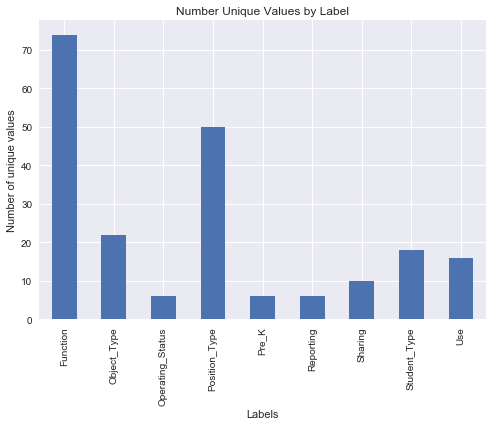

In [4]:
#The list of labels we want to classify each budget line item is below. 
LABELS=['Function', 'Object_Type', 'Operating_Status', 'Position_Type','Pre_K', 'Reporting','Sharing','Student_Type','Use']

# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = budget_df[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.title('Number Unique Values by Label')

# Display the plot
plt.show()

There are over 100 unique labels, which means that the model will need to predict over 100 target variables.

In [5]:
#inspect the value types of the variables
budget_df.dtypes.value_counts()

object     23
float64     2
dtype: int64

All of the string variables are of the object data type. In order to include them in the algorithm, they need to be converted to category type.

In [6]:
# Define the lambda function: categorize_label
categorize_label=lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
budget_df[LABELS] = budget_df[LABELS].apply(categorize_label,axis=0)

# Print the converted dtypes to make sure it worked
print(budget_df[LABELS].dtypes)

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object


In addition, the "Total" variable has some NaN values. This should be converted to a number other than zero, so the model knows to treat them differently.

In [7]:
# Recode the numeric na values to -1000 so that our algorithm treats them differently than 0
NUMERIC_COLUMNS=['FTE','Total']

# Create the new DataFrame: numeric_data_only
numeric_data_only = budget_df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(budget_df[LABELS])

Because the model will be processing such a large number of target labels, the data need to be split in a way such that both the training and test data have each target label represented.

In [8]:
#next, we need to draw a multilabel sample to account for the fact that we have multiple labels.
def multilabel_sample(y, size=1000, min_count=2, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=2, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=2, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

# Create the new DataFrame: numeric_data_only
numeric_data_only = budget_df[NUMERIC_COLUMNS].fillna(-1000)

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(budget_df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in budget_df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(budget_df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)



For now, use a "Bag of Words" approach to tokenize alphanumeric characters in the free-form text columns. Since each observation's free form text is spread over multiple columns, the columns first need to be concatenated into a single vector.

In [9]:
# set default tokens pattern for count vectorizer
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# next, get data ready for vectorizing
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

# Create the text vector
text_vector = combine_text_columns(budget_df)

Lastly, I use interactions in order to account for the effects of words that appear together in the word vectors.

In [10]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

<b>3. Results and Model Evaluation</b>

I start by fitting a multinomial logistic regression classifier. This assumes...

Things to try next:
<br>TFIDF
<br>Naive Bayes
<br>Word2Vec (will it be too computationally expensive?)
<br>Grid Search
<br>Stemming/Stop Word Removal

In [ ]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# since the data are so big, use HashingVectorizer instead of CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1, 2)))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

In [ ]:
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
